## Lecture 4 — Data (BCRP + Yahoo) + Plots + Stats + VaR 

Reproduce the key parts of the lecture notebook using:

- **Peru (BCRP API)**: `PD04637PD`, `PD04639PD`, `PD04704XD`, `PD04701XD`  
  *(FX + commodities exactly as in the notebook)*
- **USA (yfinance)**: `SPY`, `TLT`, `GLD`

**Deliverables**
- Multiple **plots** (including **one with annotations**)  
- A **summary statistics table**  
- **Historical 95% VaR** for a **60/40 portfolio** (SPY/TLT)

1. Build (and display) the **BCRPData API URL** that requests the 4 series used in the notebook.  


In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 120)

In [9]:
from __future__ import annotations

from pathlib import Path
import hashlib
import re
from io import StringIO

import numpy as np
import pandas as pd

# Configuration


CACHE_DIR = Path(".cache")
CACHE_DIR.mkdir(exist_ok=True)

# Cache utilities (parquet -> csv fallback)

def _hash_key(*parts: object) -> str:
    h = hashlib.sha256()
    for p in parts:
        h.update(str(p).encode("utf-8"))
        h.update(b"|")
    return h.hexdigest()[:24]

def _cache_paths(prefix: str, key: str) -> tuple[Path, Path]:
    p_parquet = CACHE_DIR / f"{prefix}_{key}.parquet"
    p_csv = CACHE_DIR / f"{prefix}_{key}.csv"
    return p_parquet, p_csv

def _read_cache_df(prefix: str, key: str) -> pd.DataFrame | None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    if p_parquet.exists():
        try:
            return pd.read_parquet(p_parquet)
        except Exception:
            pass
    if p_csv.exists():
        try:
            return pd.read_csv(p_csv)
        except Exception:
            pass
    return None

def _write_cache_df(df: pd.DataFrame, prefix: str, key: str) -> None:
    p_parquet, p_csv = _cache_paths(prefix, key)
    try:
        df.to_parquet(p_parquet, index=False)
        return
    except Exception:
        pass
    try:
        df.to_csv(p_csv, index=False)
    except Exception:
        # If caching fails, ignore silently (no exceptions)
        return

# HTTP helpers

def http_get_text(url: str, timeout: int = 30, headers: dict | None = None) -> str:
    """
    Returns response text. Raises inside, but callers wrap in try/except (no exceptions to user).
    """
    import requests

    h = {
        "User-Agent": "Mozilla/5.0 (compatible; FinanceCourse/1.0)",
        "Accept": "*/*",
    }
    if headers:
        h.update(headers)

    r = requests.get(url, timeout=timeout, headers=h)
    r.raise_for_status()
    return r.text
# Numeric + returns helpers
def parse_number(x) -> float:
    """
    Robust number parser:
      - '3,367' -> 3.367 (comma decimal)
      - '1,234.56' -> 1234.56 (comma thousands)
    """
    if x is None:
        return np.nan
    s = str(x).strip()
    if s == "" or s.lower() in {"nan", "none"}:
        return np.nan

    if "," in s and "." in s:
        s = s.replace(",", "")
    elif "," in s and "." not in s:
        s = s.replace(",", ".")

    try:
        return float(s)
    except Exception:
        return np.nan

def pct_change(s: pd.Series) -> pd.Series:
    x = pd.to_numeric(s, errors="coerce")
    return x.pct_change(fill_method=None).replace([np.inf, -np.inf], np.nan)
# BCRP parsing

_SP2EN = {
    "Ene": "Jan", "Feb": "Feb", "Mar": "Mar", "Abr": "Apr", "May": "May", "Jun": "Jun",
    "Jul": "Jul", "Ago": "Aug", "Set": "Sep", "Sep": "Sep", "Oct": "Oct", "Nov": "Nov", "Dic": "Dec",
}

def _clean_bcrp_payload(txt: str) -> str:
    """
    BCRP sometimes returns "CSV" wrapped as HTML with <br> line breaks.
    Normalize to plain text with real newlines.
    """
    x = txt.replace("\r\n", "\n").replace("\r", "\n")
    x = x.replace("<br/>", "\n").replace("<br />", "\n").replace("<br>", "\n")
    x = re.sub(r"</?pre[^>]*>", "", x, flags=re.IGNORECASE)
    return x.strip()

def _detect_sep(header_line: str) -> str:
    return ";" if header_line.count(";") > header_line.count(",") else ","

def _parse_bcrp_date(s: pd.Series) -> pd.Series:
    """
    Parses common BCRP date formats:
      - Daily: 2022-01-03, 03Jan22, 03Ene22
      - Monthly: Jan22, Ene22, 2022-1, 2022-01
      - Yearly: 2022
    """
    x = s.astype(str).str.strip()
    x = x.str.replace(".", "", regex=False)

    y = x
    for k, v in _SP2EN.items():
        y = y.str.replace(k, v, regex=False)

    dt = pd.to_datetime(y, format="%Y-%m-%d", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%d%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%b%y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y-%m", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], format="%Y", errors="coerce")

    m = dt.isna()
    if m.any():
        dt.loc[m] = pd.to_datetime(y[m], errors="coerce")

    return dt


def bcrp_series_csv(
    series_codes: list[str],
    start: str,
    end: str,
    lang: str = "ing",
) -> pd.DataFrame:
    """
    BCRPData API (CSV):
      https://estadisticas.bcrp.gob.pe/estadisticas/series/api/[codes]/csv/[start]/[end]/[lang]

    Returns LONG DataFrame:
      date, series_name, value

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    codes = "-".join(series_codes)
    url = f"https://estadisticas.bcrp.gob.pe/estadisticas/series/api/{codes}/csv/{start}/{end}/{lang}"

    key = _hash_key("bcrp", url)
    cached = _read_cache_df("bcrp", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        txt = http_get_text(url, timeout=30)
        txt = _clean_bcrp_payload(txt)

        lines = [ln for ln in txt.split("\n") if ln.strip() != ""]
        if len(lines) < 2:
            print("[BCRP] Endpoint returned no usable rows. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        sep = _detect_sep(lines[0])
        df = pd.read_csv(StringIO("\n".join(lines)), sep=sep)

        if df.shape[0] == 0 or df.shape[1] < 2:
            print("[BCRP] Returned an empty table. Continuing...")
            return pd.DataFrame(columns=["date", "series_name", "value"])

        date_col = df.columns[0]
        value_cols = list(df.columns[1:])

        out = df.melt(
            id_vars=[date_col],
            value_vars=value_cols,
            var_name="series_name",
            value_name="value_raw",
        ).rename(columns={date_col: "date"})

        out["date"] = _parse_bcrp_date(out["date"])
        out["value"] = out["value_raw"].map(parse_number)

        out = out.drop(columns=["value_raw"])
        out = out.dropna(subset=["date"]).sort_values(["series_name", "date"]).reset_index(drop=True)

        _write_cache_df(out, "bcrp", key)
        return out

    except Exception as e:
        print(f"[BCRP] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "series_name", "value"])

In [12]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)
print(peru)

           date                                        series_name       value
0    2022-01-03  Cotizaciones internacionales - Cobre (Londres,...  439.621725
1    2022-01-04  Cotizaciones internacionales - Cobre (Londres,...  438.170229
2    2022-01-05  Cotizaciones internacionales - Cobre (Londres,...  443.522619
3    2022-01-06  Cotizaciones internacionales - Cobre (Londres,...  433.861102
4    2022-01-07  Cotizaciones internacionales - Cobre (Londres,...  436.129064
...         ...                                                ...         ...
4131 2025-12-12  Tipo de cambio - TC Sistema bancario SBS (S/ p...    3.363000
4132 2025-12-15  Tipo de cambio - TC Sistema bancario SBS (S/ p...    3.365000
4133 2025-12-16  Tipo de cambio - TC Sistema bancario SBS (S/ p...    3.366000
4134 2025-12-17  Tipo de cambio - TC Sistema bancario SBS (S/ p...    3.365000
4135 2025-12-18  Tipo de cambio - TC Sistema bancario SBS (S/ p...    3.363000

[4136 rows x 3 columns]


2. Download those series and build a **tidy** table: `date`, `series`, `value`.  


In [14]:
START_D = "2022-01-01"
END_D   = "2025-12-18"

peru_tidy = bcrp_series_csv(
    series_codes=["PD04637PD", "PD04639PD", "PD04704XD", "PD04701XD"],
    start=START_D,
    end=END_D,
    lang="ing"
)

peru_tidy = peru_tidy.rename(columns={
    "series_name": "series"
})

peru_tidy.head()

,date,series,value
0,2022-01-03,"Cotizaciones internacionales - Cobre (Londres,...",439.621725
1,2022-01-04,"Cotizaciones internacionales - Cobre (Londres,...",438.170229
2,2022-01-05,"Cotizaciones internacionales - Cobre (Londres,...",443.522619
3,2022-01-06,"Cotizaciones internacionales - Cobre (Londres,...",433.861102
4,2022-01-07,"Cotizaciones internacionales - Cobre (Londres,...",436.129064


3. Clean to **wide format** with columns: `fx_interbank`, `fx_sbs`, `gold`, `copper` (as in the notebook).  


In [13]:
usa = yfinance_download(["SPY", "TLT", "GLD"], start=START_D, end=END_D)

print("Peru rows:", peru.shape[0], "| USA rows:", usa.shape[0])

# show in English (wide + renamed)
peru_wide = (
    peru.pivot_table(index="date", columns="series_name", values="value", aggfunc="last")
        .reset_index()
        .sort_values("date")
)
peru_wide.columns.name = None

rename_map = {}
for c in peru_wide.columns:
    cl = str(c).lower()
    if "interbanc" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_interbank_buy"
    elif "sbs" in cl and ("tipo de cambio" in cl or "tc" in cl or "exchange" in cl):
        rename_map[c] = "fx_sbs_buy"
    elif "oro" in cl or "gold" in cl:
        rename_map[c] = "gold_london"
    elif "cobre" in cl or "copper" in cl:
        rename_map[c] = "copper_london"

peru_wide = peru_wide.rename(columns=rename_map)
peru_wide.head()

Peru rows: 4136 | USA rows: 2982


,date,copper_london,gold_london,fx_interbank_buy,fx_sbs_buy
0,2022-01-03,439.621725,1820.10,3.983667,3.987
1,2022-01-04,438.170229,1811.40,3.959500,3.963
2,2022-01-05,443.522619,1826.25,3.952000,3.953
3,2022-01-06,433.861102,1789.35,3.967167,3.967
4,2022-01-07,436.129064,1792.60,3.945167,3.948


4. Download `SPY`, `TLT`, `GLD` from yfinance and build: `date`, `ticker`, `close`.  


In [8]:
# Yahoo Finance (yfinance)

def yfinance_download(tickers: list[str], start: str, end: str) -> pd.DataFrame:
    """
    Yahoo Finance via yfinance.
    Returns LONG DataFrame:
      date, ticker, close, volume, ret

    If the endpoint fails, prints a short message and returns an empty DataFrame (no exceptions).
    """
    try:
        import yfinance as yf
    except Exception:
        print("[yfinance] yfinance not installed/importable. Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

    key = _hash_key("yfinance", " ".join(tickers), start, end)
    cached = _read_cache_df("yf", key)
    if cached is not None and cached.shape[0] > 0:
        cached["date"] = pd.to_datetime(cached["date"], errors="coerce")
        return cached

    try:
        data = yf.download(tickers=tickers, start=start, end=end, auto_adjust=False, progress=False)
        if data is None or data.shape[0] == 0:
            print("[yfinance] Returned no rows. Continuing...")
            return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

        frames = []
        if isinstance(data.columns, pd.MultiIndex):
            for t in tickers:
                if t not in data.columns.get_level_values(1):
                    continue
                sub = data.xs(t, axis=1, level=1).copy()
                sub = sub.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
                sub["ticker"] = t
                sub = sub.rename(columns={"Close": "close", "Volume": "volume"})
                frames.append(sub[["date", "ticker", "close", "volume"]])
            out = pd.concat(frames, ignore_index=True) if frames else pd.DataFrame()
        else:
            out = data.reset_index().rename(columns={"Date": "date", "Datetime": "date"})
            out["ticker"] = tickers[0]
            out = out.rename(columns={"Close": "close", "Volume": "volume"})
            out = out[["date", "ticker", "close", "volume"]]

        out["date"] = pd.to_datetime(out["date"], errors="coerce")
        out["close"] = pd.to_numeric(out["close"], errors="coerce")
        out["volume"] = pd.to_numeric(out["volume"], errors="coerce")

        out = out.dropna(subset=["date", "close"]).sort_values(["ticker", "date"]).reset_index(drop=True)
        out["ret"] = out.groupby("ticker")["close"].apply(pct_change).reset_index(level=0, drop=True)

        _write_cache_df(out, "yf", key)
        return out

    except Exception as e:
        print(f"[yfinance] Endpoint unavailable ({type(e).__name__}). Continuing...")
        return pd.DataFrame(columns=["date", "ticker", "close", "volume", "ret"])

In [5]:
import yfinance as yf

tickers = ["SPY", "TLT", "GLD"]

us_mkt = (
    yf.download(
        tickers,
        start="2020-01-01",
        end="2024-12-31",
        auto_adjust=True
    )["Close"]
)

us_mkt.head()

[*********************100%***********************]  3 of 3 completed


Ticker,GLD,SPY,TLT
Date,,,
2020-01-02,143.949997,297.698975,115.443687
2020-01-03,145.860001,295.444733,117.221581
2020-01-06,147.389999,296.571899,116.555954
2020-01-07,147.970001,295.737976,115.983009
2020-01-08,146.860001,297.314117,115.216225


5. Compute **daily returns** by ticker (`ret`) and validate there are **no inf values**.


In [19]:
usa_tidy = (
    usa[["date", "ticker", "close"]]
    .rename(columns={"ticker": "series", "close": "value"})
    .copy()
)

usa_tidy.head()

,date,series,value
0,2022-01-03,GLD,168.330002
1,2022-01-04,GLD,169.570007
2,2022-01-05,GLD,169.059998
3,2022-01-06,GLD,166.990005
4,2022-01-07,GLD,167.750000


In [21]:
usa_tidy = usa_tidy.sort_values(["series", "date"])

In [25]:
usa_tidy["ret"] = (
    usa_tidy
    .groupby("series")["value"]
    .pct_change()
)
usa_tidy

,date,series,value,ret
0,2022-01-03,GLD,168.330002,NaN
1,2022-01-04,GLD,169.570007,0.007367
2,2022-01-05,GLD,169.059998,-0.003008
3,2022-01-06,GLD,166.990005,-0.012244
4,2022-01-07,GLD,167.750000,0.004551
...,...,...,...,...
2977,2025-12-11,TLT,88.190002,-0.001359
2978,2025-12-12,TLT,87.339996,-0.009638
2979,2025-12-15,TLT,87.400002,0.000687
2980,2025-12-16,TLT,87.879997,0.005492


In [26]:
np.isinf(usa_tidy["ret"]).sum()

np.int64(0)

In [27]:
usa_tidy.head()

,date,series,value,ret
0,2022-01-03,GLD,168.330002,NaN
1,2022-01-04,GLD,169.570007,0.007367
2,2022-01-05,GLD,169.059998,-0.003008
3,2022-01-06,GLD,166.990005,-0.012244
4,2022-01-07,GLD,167.750000,0.004551


6. *(Quantities)* Compare FX levels in Peru: produce a **plot** and a short comment.  


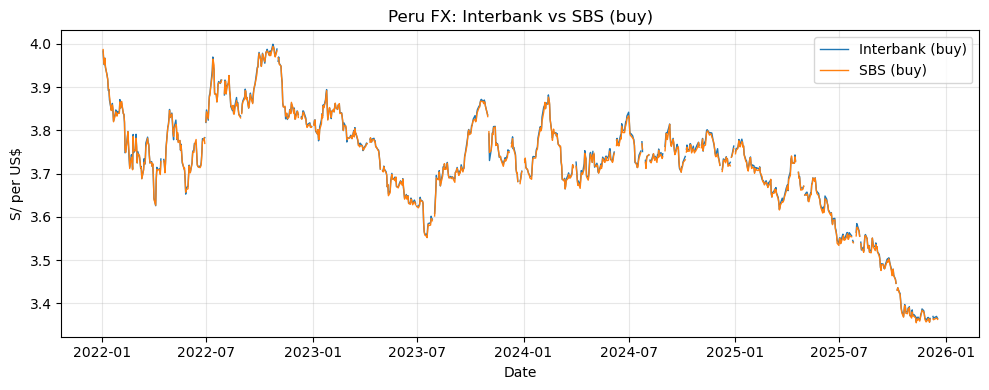

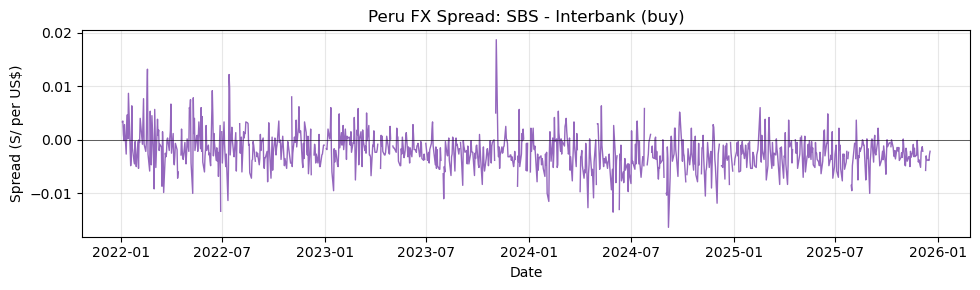

In [48]:
# Exercise 1.1 — FX level comparison (Peru)
# Uses existing variables: `peru`, `peru_wide`, `rename_map`

# 1) Filter peru to the two FX series (Interbank buy and SBS buy)
fx_keys = [k for k, v in rename_map.items() if v in {"fx_interbank_buy", "fx_sbs_buy"}]
fx_long = peru[peru["series_name"].isin(fx_keys)].copy()

# 2) Pivot to wide format (date as index) and rename to short names
fx_wide = (
    fx_long.pivot(index="date", columns="series_name", values="value")
    .rename(columns=rename_map)
    .reset_index()
    .sort_values("date")
)

# If pivot produced missing columns, try to use existing peru_wide as fallback
needed_cols = {"fx_interbank_buy", "fx_sbs_buy"}
if not needed_cols.issubset(set(fx_wide.columns)):
    fx_wide = peru_wide[["date", "fx_interbank_buy", "fx_sbs_buy"]].copy()

# 3) Plot both FX levels in the same line chart
comment = (
    "Interbank and SBS FX rates move almost identically,\n"
    "indicating a well-integrated FX market with\n"
    "minimal and transitory pricing differences."
)
plt.figure(figsize=(10, 4))
plt.plot(fx_wide["date"], fx_wide["fx_interbank_buy"], label="Interbank (buy)", linewidth=1)
plt.plot(fx_wide["date"], fx_wide["fx_sbs_buy"], label="SBS (buy)", linewidth=1)
plt.title("Peru FX: Interbank vs SBS (buy)")
plt.ylabel("S/ per US$")
plt.xlabel("Date")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Create spread = sbs - interbank and plot it in a separate figure
fx_wide["spread"] = fx_wide["fx_sbs_buy"] - fx_wide["fx_interbank_buy"]

plt.figure(figsize=(10, 3))
plt.plot(fx_wide["date"], fx_wide["spread"], color="tab:purple", linewidth=1)
plt.axhline(0, color="black", linewidth=0.7, alpha=0.6)
plt.title("Peru FX Spread: SBS - Interbank (buy)")
plt.ylabel("Spread (S/ per US$)")
plt.xlabel("Date")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

7. *(Proportions)* Compute the **share of positive-return days** by ticker (USA).  


In [32]:
# Exercise 2.1 — Share of positive-return days (USA)

# 1) For each ticker in `usa`, compute the share of days with ret > 0
share_positive = usa.dropna(subset=['ret']).groupby('ticker').apply(
    lambda x: (x['ret'] > 0).sum() / len(x)
).reset_index()
share_positive.columns = ['ticker', 'share_positive']

print(share_positive)

  ticker  share_positive
0    GLD        0.545821
1    SPY        0.535750
2    TLT        0.493454


C:\Users\USER\AppData\Local\Temp\ipykernel_8144\4138612874.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  share_positive = usa.dropna(subset=['ret']).groupby('ticker').apply(


8. Plot that share as a **bar chart** and add **labels above each bar** (`annotate`).  


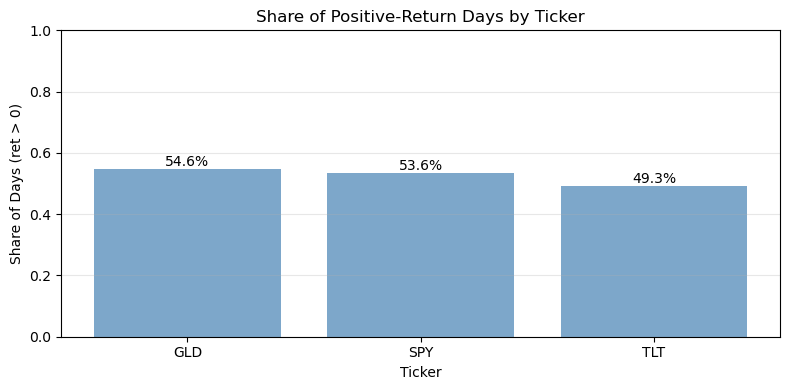

In [33]:

# 2) Plot a bar chart of these shares
plt.figure(figsize=(8, 4))
bars = plt.bar(share_positive['ticker'], share_positive['share_positive'], color='steelblue', alpha=0.7)
plt.title('Share of Positive-Return Days by Ticker')
plt.ylabel('Share of Days (ret > 0)')
plt.xlabel('Ticker')
plt.ylim(0, 1)

# 3) Add labels (percent format) and a title
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1%}',
             ha='center', va='bottom', fontsize=10)

plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

9. *(Distributions)* Compare the distribution of **Peru Gold** vs **GLD** (histogram).  


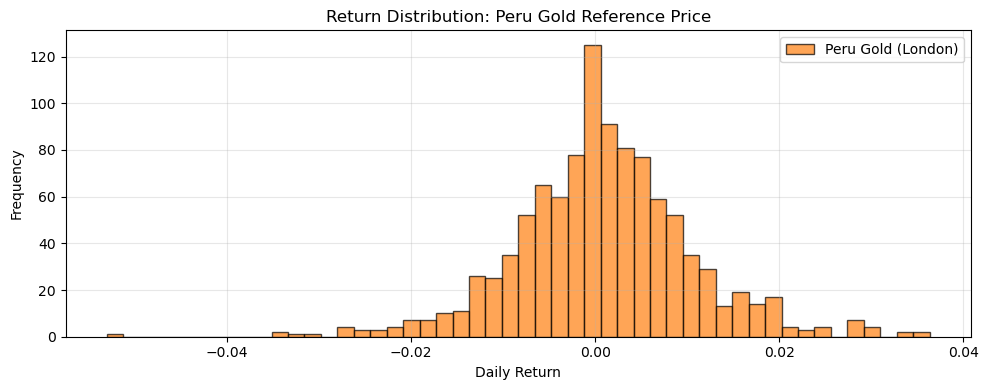

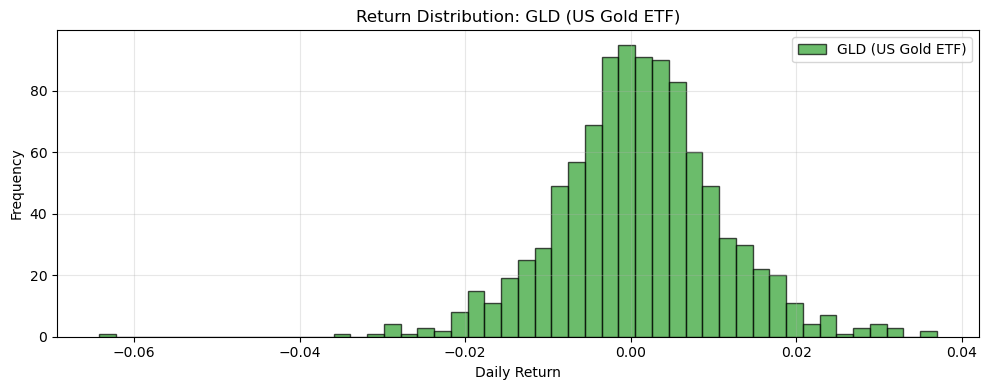

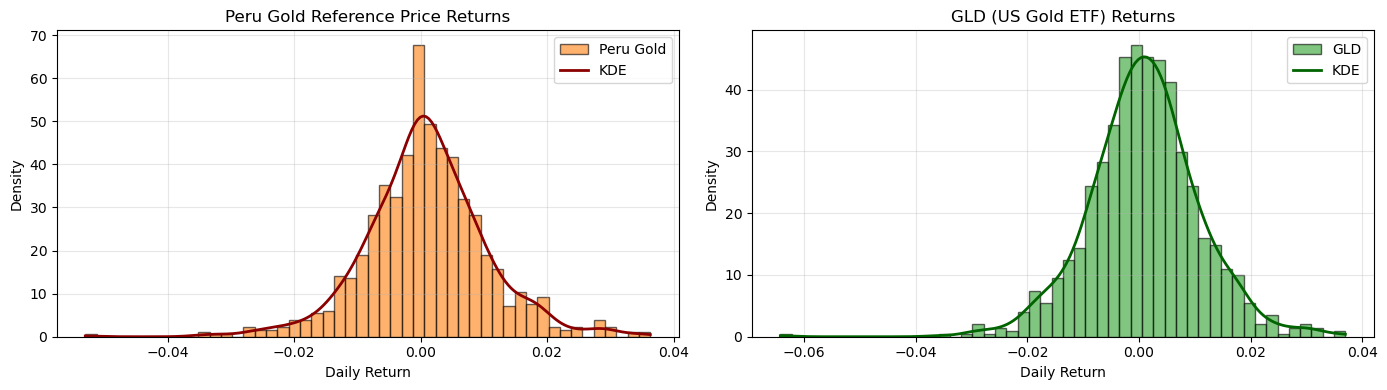

In [34]:

from scipy import stats

# Exercise 3.1 — Return distributions: Peru Gold vs US Gold ETF

# 1) From peru, build a daily gold series and compute returns
peru_gold = peru_wide[['date', 'gold_london']].copy()
peru_gold.columns = ['date', 'value']
peru_gold = peru_gold.sort_values('date').reset_index(drop=True)
peru_gold['gold_ret'] = pct_change(peru_gold['value'])

# 2) From usa, filter to GLD returns
gld_data = usa[usa['ticker'] == 'GLD'].copy().sort_values('date').reset_index(drop=True)

# 3) Plot two histograms (separate figures) with the same binning
bins = 50

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(peru_gold['gold_ret'].dropna(), bins=bins, alpha=0.7, color='tab:orange', label='Peru Gold (London)', edgecolor='black')
ax.set_title('Return Distribution: Peru Gold Reference Price')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.hist(gld_data['ret'].dropna(), bins=bins, alpha=0.7, color='tab:green', label='GLD (US Gold ETF)', edgecolor='black')
ax.set_title('Return Distribution: GLD (US Gold ETF)')
ax.set_xlabel('Daily Return')
ax.set_ylabel('Frequency')
ax.legend()
ax.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4) Optional: overlay KDE for each distribution

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Peru Gold
peru_ret_clean = peru_gold['gold_ret'].dropna()
ax1.hist(peru_ret_clean, bins=bins, alpha=0.6, color='tab:orange', label='Peru Gold', density=True, edgecolor='black')
if len(peru_ret_clean) > 1:
    kde_peru = stats.gaussian_kde(peru_ret_clean)
    x_range = np.linspace(peru_ret_clean.min(), peru_ret_clean.max(), 200)
    ax1.plot(x_range, kde_peru(x_range), color='darkred', linewidth=2, label='KDE')
ax1.set_title('Peru Gold Reference Price Returns')
ax1.set_xlabel('Daily Return')
ax1.set_ylabel('Density')
ax1.legend()
ax1.grid(alpha=0.3)

# GLD
gld_ret_clean = gld_data['ret'].dropna()
ax2.hist(gld_ret_clean, bins=bins, alpha=0.6, color='tab:green', label='GLD', density=True, edgecolor='black')
if len(gld_ret_clean) > 1:
    kde_gld = stats.gaussian_kde(gld_ret_clean)
    x_range = np.linspace(gld_ret_clean.min(), gld_ret_clean.max(), 200)
    ax2.plot(x_range, kde_gld(x_range), color='darkgreen', linewidth=2, label='KDE')
ax2.set_title('GLD (US Gold ETF) Returns')
ax2.set_xlabel('Daily Return')
ax2.set_ylabel('Density')
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

10. Add an **ECDF** (if used in the notebook) and comment on what changes vs the histogram.  


In [37]:
peru_tidy = peru_tidy.sort_values(["series", "date"])

peru_tidy["ret"] = (
    peru_tidy
    .groupby("series")["value"]
    .pct_change()
)

C:\Users\USER\AppData\Local\Temp\ipykernel_8144\4264023692.py:6: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  .pct_change()


In [38]:
peru_gold = peru_tidy[peru_tidy["series"] == "PD04704XD"].dropna()

In [40]:
gld = usa_tidy[usa_tidy["series"] == "GLD"].dropna()

In [41]:
print(peru_gold.columns)

Index(['date', 'series', 'value', 'ret'], dtype='object')


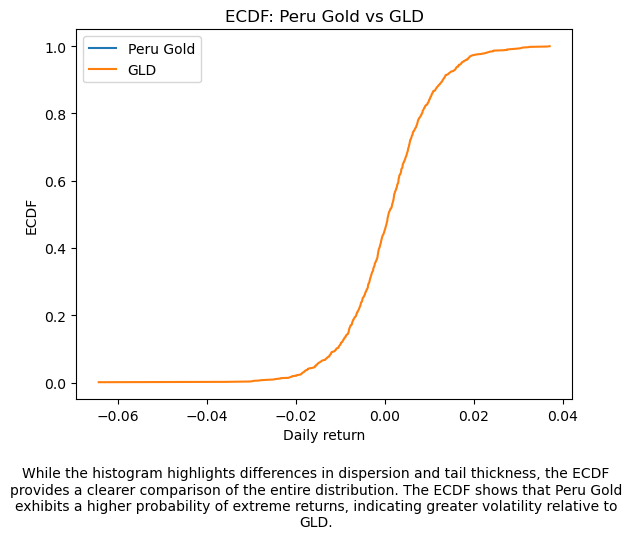

In [45]:
import numpy as np
import matplotlib.pyplot as plt

# Ordenar retornos
peru_ret_sorted = np.sort(peru_gold["ret"].values)
gld_ret_sorted  = np.sort(gld["ret"].values)

# ECDF
peru_ecdf = np.arange(1, len(peru_ret_sorted) + 1) / len(peru_ret_sorted)
gld_ecdf  = np.arange(1, len(gld_ret_sorted) + 1) / len(gld_ret_sorted)

comment = (
    "While the histogram highlights differences in dispersion and tail thickness, "
    "the ECDF provides a clearer comparison of the entire distribution. "
    "The ECDF shows that Peru Gold exhibits a higher probability of extreme returns, "
    "indicating greater volatility relative to GLD."
)

plt.figure()
plt.plot(peru_ret_sorted, peru_ecdf, label="Peru Gold")
plt.plot(gld_ret_sorted, gld_ecdf, label="GLD")
plt.xlabel("Daily return")
plt.ylabel("ECDF")
plt.title("ECDF: Peru Gold vs GLD")
plt.legend()

# Comentario debajo del gráfico
plt.figtext(
    0.5, -0.15, comment,
    ha="center",
    wrap=True,
    fontsize=10
)

plt.show()